# Solving special values

While the variable $x$ of a PGF $G(x)$ is often meant to simply be interpreted as a counting variable, it can also sometimes be interpreted as a probability.

## Probability of extinction

Consider a simple cell division process: A cell successfully divides in two with probability $p$, or dies trying with probability $1-p$. Using the definition of PGFs, we can define $G(x)$ to be the PGF of the count of live cells at the end of the lifetime of a given cell:

$$
G(x) = (1-p) + px^2 \; .
$$

If $p=1$, then obviously the cell population will grow exponentially to infinity. If $p=0$, the population dies immediately. What happens in between?

We define $u$ to be the probability that the descendence of a cell does not grow to an infinite population. For a given cell to not lead to an infinite population, none of their descendents can lead to an infinite population (this is called a *self-consistent definition*, more on that later). 

We can therefore take two perspective. Looking at a given live cell which does not lead to an infinite population must be equivalent to looking at its potential offsprings and requiring that none of them lead to an infinite population. Since these two definitions are equal, we write:

$$
u = (1-p) +pu^2 = G(u) \; .
$$

Solving for the smallest real positive root of the polynomial $G(x) - x$ is therefore equivalent to solving for the probability that a population does not live forever. We say the smallest real positive root because the polynomial can have multiple roots and because 1 is always a root (since $G(x)$ is a PGF such that $G(1) = 1$).

Solving for roots of a PGF is actually super easy, barely an inconvenience. We are trying to find where some PGF $G(x)$ crosses $x$ (or the diagonal. There are really only two possibilities for how this situation can look:

![PGF-roots](./assets/png/roots.png)

We know for certain that $G(x)$ starts at $G(0)=p_0\geq 0$ and ends at $G(1) = 1$. We also know that all of its derivatives are positive (since its coefficients $p_k \geq 0$ for all $k$. Therefore, it either touches the diagonal once before $G(1) = 1$, or never. The key distinction between the two scenarios is the derivative $dG(x)/dx=G'(x)$ at $x=1$. If $G'(1)>1$, then $G(x)$ *has* to touch the diagonal at some value $0 \leq x < 1$. That value will be $x=0$ if $p_0 = 0$, or greater than 0 otherwise.

In practice, we want to solve for the exact value of $u$; i.e., the crossing of $G(x)$ and $x$ where $G(x)-x=0$. Luckily, because PGFs are so constrained by the fact that all their coefficients are greater or equal to zero, we can simply iterate the self-consistent definition. We can start at some random value $x_0<1$ and go to $x_{n+1} = G(x_n)$ until we converge to withing some satisfactory precision of $x_{\infty}=u$. One can inspect the shape of the graph below to understand why that works, and the same logic will hold if we start at $x_0<u$:

![PGF-iterations](./assets/png/iteration.png)

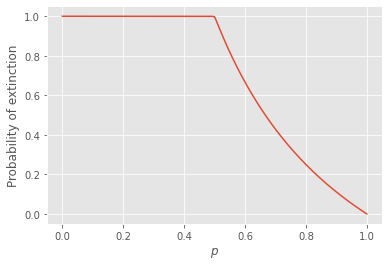

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

G = lambda p,x: (1-p)+p*x**2
plist = np.linspace(0.0,1.0,1000)
usol = []
Pext = []
for p in reversed(plist):
    u1 = usol[-1].copy() if usol else 0.5
    u2 = G(p,u1)
    while  abs(u2-u1) > 10**(-5):
        u1 = u2.copy()
        u2 = G(p,u1)
    usol.append(u2)
    Pext.append(u2)
Pext = list(reversed(Pext))
plt.plot(plist,Pext)
plt.xlabel(r"$p$")
plt.ylabel(r"Probability of extinction")
plt.show()

## Faster convergence

In the code above, we keep track of our current estimate for $u$ which we call $u_1$ and update it to $u_2 = G(u_1)$ until $\vert u2-u1\vert > 10^{-5}$. We do use one easy trick to speed up the convergence though: Since we are going through values of the parameter $p$ consecutively, we start our iteration at a $u_1$ value that corresponds to the previous converged value (or 0.5 if this is the first value we test). Since we expect that the exact value of $u$ must vary continuously with $p$, starting the iterative process for $p$ at the solution for $p'$ means that we are starting close to the new solution.

We can achieve even faster convergence.

To find the zero of a continuous function, one incredibly simple idea known as [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) is to assume that the function is linear. Given some current estimate $x_n$, we track the slope until we reach zero and call this our new estimate $x_{n+1}$. We then repeat until convergence. Since the slope can be approximated as the change in value over the change in $x$, we can derive an easy relationship between $x_n$, $x_{n+1}$ and the slope.

$$
\frac{d}{dx} \left[G(x) - x\right]\big\vert_{x=x_n} = G'(x_n)-1 = \frac{G(x_n)-x_n-0}{x_n-x_{n+1}} \rightarrow x_{n+1} = x_n - \frac{G(x_n)-x_n}{G'(x_n) - 1}
$$
which can be understood visually as follows.

![Newton-method](./assets/png/newton.png)

If we do not want to have to evaluate both $G(x)$ and its derivative $G'(x_n)$, we can also rely on a simple approximation of the slope. The approach is then known as [Steffensen's method](https://en.wikipedia.org/wiki/Steffensen%27s_method). The approximation goes as follows:

$$
f'(x) \approx g(x) = \frac{f(x+f(x))}{f(x)} - 1 \; .
$$
Which in the case of the function we care about, $f(x) = G(x)-x$, becomes
$$
G'(x_n)-1 \approx \frac{G(G(x_n))-2G(x_n)+x_n}{G(x_n)-x_n}
$$

This approach can be impletemented as follows and compared to the previous 'direct' approach. While it is *much* faster, the code is a little less neat: We have to evaluate the PGF a lot and test that the slope isn't too close to zero to avoid numerical issues. While in practice we might often use Steffensen's method, we use the direct approach in much of this sourcebook in the spirit of code readability.

In [41]:
#Direct iteration
G = lambda p,x: (1-p)+p*x**2
p = 0.6
u1 = 0.5
u2 = G(p,u1)
iter_direct = 1
while  abs(u2-u1) > 10**(-15):
    u1 = u2
    u2 = G(p,u1)
    iter_direct+=1

print('Direct iteration took '+str(iter_direct)+' iterations to find u = '+str(u2))

Direct iteration took 139 iterations to find u = 0.6666666666666634


In [43]:
#Steffensen's method
G = lambda p,x: (1-p)+p*x**2
p = 0.6
u1 = 0.5
u2 = G(p,u1)
iter_steffensen = 1
while  abs(u2-u1) > 10**(-15):
    u1 = u2
    denominator = (G(p,G(p,u1))-2*G(p,u1)+u1)/(G(p,u1)-u1)
    if abs(denominator)<10**(-15): #otherwise we can have numerical issue when very close
        u2=u1
    else:
        u2 = u1-(G(p,u1)-u1)/denominator
    iter_steffensen+=1
    
print('Steffensen took '+str(iter_steffensen)+' iterations to find u = '+str(u2))

Steffensen took 7 iterations to find u = 0.6666666666666679


:::{seealso}
There are other methods for convergence, such as [Aitken's delta-squared process or Aitken extrapolation](https://en.wikipedia.org/wiki/Aitken%27s_delta-squared_process). But the authors have found the method described here to be preferred in most situations.
:::

## Distribution conditioned on extinction

Even when random events are independent realizations of a stochastic process with known parameters, they can become correlated or their observed parameters might change once we condition on their outcome. Here is a simple example, say that we flip an unbiased coin such that (a priori) we get 'tails' 50\% of the time, and keep flipping until we get 'heads' then stop. Conditioned on a total sequence being of length two, the first flip is now 100\% tails and the second flip is now 100\% heads, not the 50/50 split expected before the flip. 

What does this mean for our cell division example? Given a probability of successful cell division $p$, we now know how to calculate the probability of extinction $u$. If we are interested in specifically studying the dynamics of cell lineage that go extinct, what is the effective probability of successful cell division $p'$ that govern their dynamics?

Looking at the first cell in the now extinct lineage, we know that it can fail to divide, or that if it does divide, none of their descendents can lead to an infinite population. The cell therefore divides according to the following generating function

$$
G'(x) \propto (1-p)+pu^2 x^2
$$

and normalizing to get a proper PGF

$$
G'(x) = \frac{(1-p)+pu^2 x^2}{G(u)} = \frac{1}{u}G(ux) \; .
$$

Say the true dynamics of the cells actually lead to a probability of succesfull division of $p=0.6$. We saw that a population of cells therefore has a probability of $u=0.666$ of going extinct. This means that when looking at the dynamics of lineages that do go extinct, the effective probability of succesful division is only $p' = pu^2 = 0.266$. 

What does this mean? Even though the first cell is more likely to divide then die, when looking at finite populations of cells that went extinct, the vast of these will have gone extinct with their first cell not dividing. Stochastic processes are not always intuitive!